# Poisson problem (1D/2D)

In [ ]:


from cuqi.problem import BayesianProblem
from cuqi.distribution import Gaussian
from cuqipy_fenics.utilities import ExpressionFromCallable
from cuqipy_fenics.testproblem import FEniCSPoisson2D, FEniCSDiffusion1D
from cuqi.experimental.mcmc import MH, NUTS, MALA, ULA, MYULA
from cuqi.implicitprior import RestorationPrior, MoreauYoshidaPrior
import numpy as np
import cuqi
import cuqipy_fenics
import dolfin as dl
import matplotlib.pyplot as plt
# import check_grad
from scipy.optimize import check_grad
from cuqi.utilities import approx_gradient
from skimage.restoration import denoise_tv_chambolle
import os

# set logging level of dl
dl.set_log_level(dl.LogLevel.ERROR)


In [10]:
cuqipy_fenics.__file__

'/Users/amal/Documents/research_code/CUQI-DTU/CUQIpy-FEniCS/cuqipy_fenics/__init__.py'

Print CUQIpy and CUQIpy-FEniCS versions:

In [11]:
print(cuqi.__version__)
print(cuqipy_fenics.__version__)
print(cuqipy_fenics.__file__)

0+untagged.3719.g231aec2
0+untagged.256.g7d0d1eb
/Users/amal/Documents/research_code/CUQI-DTU/CUQIpy-FEniCS/cuqipy_fenics/__init__.py


In [ ]:
# read command line arguments

import argparse
parser = argparse.ArgumentParser(description='Run MCMC for a given problem')
parser.add_argument('--smoothing_factor', type=float, default=None, help='Smoothing factor for the TV prior')
parser.add_argument('--regularization_strength', type=float, default=None, help='Regularization strength for the TV prior')
parser.add_argument('--par_dim', type=int, default=None, help='Dimension of the parameter space')

args = parser.parse_args(os.environ['NB_ARGS'].split())



In [13]:

model_type = 'diffusion_2D'  #'convolution' #'convolution' #'diffusion' # 'identity' # choice of model type

enable_FD = False
#sampler_choice = "NUTS" #"MALA" #"NUTS"


In [ ]:
# parameter set up
if model_type == 'convolution':
    np.random.seed(0)
    sampler_choice = "NUTS"
    TV_weight = 1.0e2
    TV_beta = 1e-4
    plot_par = False
    Ns = 1
    Nb = 500
    max_depth = 5
    step_size = None
    remove_burnin = 0
    apply_grid_search=False
    # initial point was zero

    # these variables are not used in the deconvolution case
    source_coeff = 5
    sample_prior = False
    prior_type = 'TV'#'Gaussian' #'TV' #'Gaussian' # 'TV'
    nx = 40 if args.par_dim is None else args.par_dim

if model_type == 'diffusion':
    np.random.seed(0)
    sampler_choice = "myULA"
    TV_weight = 50 #40 #80 #40 #60
    TV_beta = 1e-7
    plot_par = True
    Ns = 1000 #1000
    Nb = 10 #20000
    max_depth = 7
    step_size = None
    remove_burnin = 200 #0#int(Nb/2) #15000
    apply_grid_search=False
    signal_type = 'square'
    set_x0_map_tobe_true = False
    run_scipy_with_callback = False
    noise_level = 0.01
    source_coeff = 1
    physical_dim = 1 # choice of physical dimension
    sample_prior = False
    prior_type = 'TV_denoiser'#'Gaussian' #'TV' #'Gaussian' # 'TV'
    smoothing_factor = 0.01 if args.smoothing_factor is None else args.smoothing_factor
    nx = 40 if args.par_dim is None else args.par_dim


if model_type == 'diffusion_2D':
    np.random.seed(0)
    sampler_choice = "myULA"
    TV_weight = 60 #35 #40 #80 #40 #60
    TV_beta = 1e-6 #1e-7
    plot_par = True
    Ns = int(2000*25) #5*20000 #1000
    Nb = 1 #20000
    max_depth = 7
    step_size = 0.005
    remove_burnin = 200 # 3000 #0#int(Nb/2) #15000
    apply_grid_search=False
    signal_type = 'square'
    set_x0_map_tobe_true = False
    run_scipy_with_callback = False
    noise_level = 0.01
    source_coeff = 1
    physical_dim = 2 # choice of physical dimension
    sample_prior = False
    prior_type = 'TV_denoiser'#'Gaussian' #'TV' #'Gaussian' # 'TV'
    regularization_strength = 20 if args.regularization_strength is None else args.regularization_strength
    smoothing_factor = 0.01 if args.smoothing_factor is None else args.smoothing_factor
    nx = 16 if args.par_dim is None else int(np.sqrt(args.par_dim))
    



    

In [15]:

if model_type == 'diffusion':
    endpoint = 10 # domain length
    # f is sum of 3 exponentials at 1/4*endpoint and 1/2*endpoint and 3/4*endpoint
    
    def f(x):
        return np.exp(-source_coeff*(x-1/4*endpoint)**2) + np.exp(-source_coeff*(x-1/2*endpoint)**2) + np.exp(-source_coeff*(x-3/4*endpoint)**2)
        #return np.ones(len(x))
    
    #plot f
    x_grid = np.linspace(0, endpoint, 100)
    plt.plot(x_grid, f(x_grid))
    
    
    f_expr = ExpressionFromCallable(f)
elif model_type == 'diffusion_2D':
    f_expr = dl.Constant(1.0)


In [ ]:
if model_type == 'diffusion_2D':
    
    A = FEniCSPoisson2D(dim=(nx,nx), field_type=None, mapping='exponential', bc_types=['Dirichlet', 'Dirichlet', 'Dirichlet', 'Dirichlet']).model
elif model_type == 'diffusion':
        A = FEniCSDiffusion1D(dim=nx, right_bc=0, f=f_expr, endpoint=endpoint).model # note source term is zero for the 1D case

elif model_type == 'identity':
    A = cuqi.model.LinearModel(np.eye(nx))

elif model_type == 'convolution':
    A = cuqi.testproblem.Deconvolution1D(dim=nx, PSF_param=2, PSF_size=nx).model

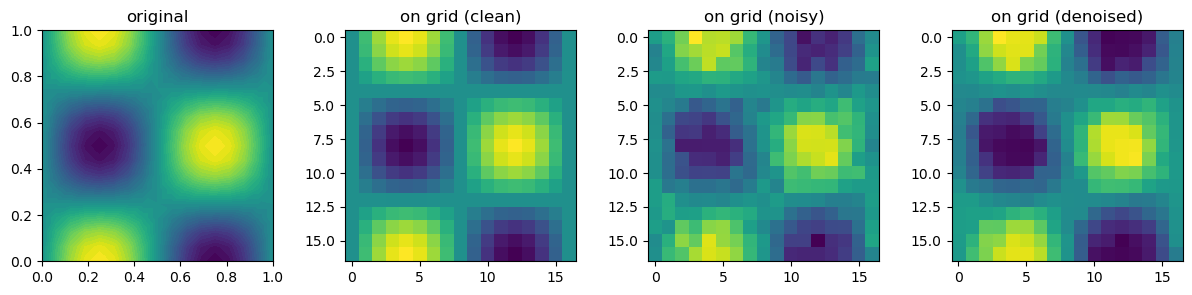

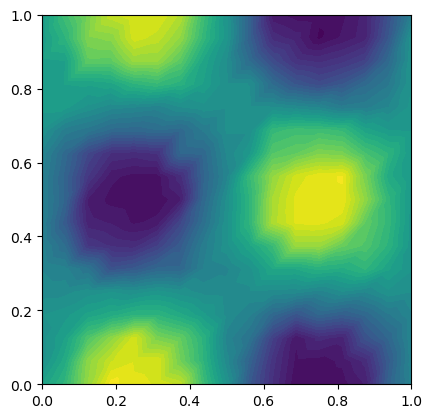

In [ ]:
# create a plot with one row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

plt.sca(axs[0])
# sin cos fenics expression
f_expr_sin_cos = dl.Expression('sin(2*pi*x[0])*cos(2*pi*x[1])', degree=2)
f_sin_cos = dl.interpolate(f_expr_sin_cos, A.domain_geometry.function_space)
dl.plot(f_sin_cos)
plt.title('original')

plt.sca(axs[1])
x_grid = f_sin_cos.compute_vertex_values().reshape((nx+1,nx+1))
plt.imshow(x_grid)
plt.title('on grid (clean)')

# add noise to x_grid
x_grid += np.random.normal(0, 0.1, x_grid.shape)
plt.sca(axs[2])
plt.imshow(x_grid)
plt.title('on grid (noisy)')

x_grid_tv = denoise_tv_chambolle(x_grid, weight=0.1, max_num_iter=100)
plt.sca(axs[3])
plt.imshow(x_grid_tv)
plt.title('on grid (denoised)')

# go back from x_grid to fenics function
fun_from_x_grid = dl.Function(A.domain_geometry.function_space)

#TODO: why d2v not v2d?
plt.figure()
v2d = dl.vertex_to_dof_map(A.domain_geometry.function_space)
d2v = dl.dof_to_vertex_map(A.domain_geometry.function_space)
fun_from_x_grid.vector()[:] = x_grid_tv.flatten()[d2v]
dl.plot(fun_from_x_grid)



In [18]:
G_domain = A.domain_geometry
G_range = A.range_geometry

In [19]:
#H_DG = A.domain_geometry.function_space
#updated_domain_geometry = cuqipy_fenics.geometry.FEniCSContinuous(H_DG)
#A.domain_geometry = updated_domain_geometry


In [20]:
# SMPrior class
class SMPrior:
    def __init__(self, ginv, corrlength, var, mean, covariancetype=None):
        self.corrlength = corrlength
        self.mean = mean
        self.c = 1e-9  # default value
        if covariancetype is not None:
            self.covariancetype = covariancetype
        else:
            self.covariancetype = 'Squared Distance'  # default
        self.compute_L(ginv, corrlength, var)

    def compute_L(self, g, corrlength, var):
        ng = g.shape[0]
        a = var - self.c
        b = np.sqrt(-corrlength**2 / (2 * np.log(0.01)))
        Gamma_pr = np.zeros((ng, ng))

        for ii in range(ng):
            for jj in range(ii, ng):
                dist_ij = np.linalg.norm(g[ii, :] - g[jj, :])
                if self.covariancetype == 'Squared Distance':
                    gamma_ij = a * np.exp(-dist_ij**2 / (2 * b**2))
                elif self.covariancetype == 'Ornstein-Uhlenbeck':
                    gamma_ij = a * np.exp(-dist_ij / corrlength)
                else:
                    raise ValueError('Unrecognized prior covariance type')
                if ii == jj:
                    gamma_ij = gamma_ij + self.c
                Gamma_pr[ii, jj] = gamma_ij
                Gamma_pr[jj, ii] = gamma_ij
        
        self.cov = Gamma_pr
        self.L = np.linalg.cholesky(np.linalg.inv(Gamma_pr)).T

    def draw_samples(self, nsamples):
        samples = self.mean + np.linalg.solve(self.L, np.random.randn(self.L.shape[0], nsamples))
        return samples

    def eval_fun(self, args):
        sigma = args[0]
        res = 0.5 * np.linalg.norm(self.L @ (sigma - self.mean))**2
        return res
    
    def evaluate_target_external(self, x, compute_grad=False):
        x = x.reshape((-1,1))
        # print("x.shape: ", x.shape)
        # print("self.mean.shape: ", self.mean.shape)
        if compute_grad:
            grad = self.L.T @ self.L @ (x - self.mean)
        else:
            grad = None
        
        return self.eval_fun(x), grad
        

    def compute_hess_and_grad(self, args, nparam):
        sigma = args[0]
        Hess = self.L.T @ self.L
        grad = Hess @ (sigma - self.mean)

        if nparam > len(sigma):
            Hess = np.block([[Hess, np.zeros((len(sigma), nparam - len(sigma)))],
                             [np.zeros((nparam - len(sigma), len(sigma))), np.zeros((nparam - len(sigma), nparam - len(sigma)))]])
            grad = np.concatenate([grad, np.zeros(nparam - len(sigma))])


        return Hess, grad

In [21]:
#class MyTV:
#    def __init__(self, q0fun, mesh, delta,**kwargs):
#        #self.qfun = project(qFunction(phi,q1,q2),V1)
#
#        self.V1 = FunctionSpace(mesh,'CG',1)
#        self.V02 = VectorFunctionSpace(mesh,'DG',0)
#
#        self.q0fun = q0fun
#        self.q0grad = project(grad(self.q0fun),self.V02)
#        self.q0_denom = Denom(self.q0grad,delta)
#
#        # operator
#        self.p_trial = TrialFunction(self.V1)
#        self.p_test = TestFunction(self.V1)
#
#        #self.L_op = assemble(ufl.inner(self.p_trial, self.p_test)*dx)
#        #self.TV_op = assemble(self.q_denom*ufl.inner(grad(self.p_trial),grad(self.p_test))*dx)
#        self.TV_op = assemble((self.q0_denom*inner(grad(self.p_trial),grad(self.p_test)))*dx)
#
#        self.delta = delta
#
#    def eval_TV(self,qfun):
#        self.update_op(qfun)
#        return np.dot(self.TV_op * qfun.vector(),qfun.vector())
#
#    def eval_grad(self,qfun):
#        self.update_op(qfun)
#        return 2*(self.TV_op * qfun.vector())#[idx2]
#    
#    def update_op(self,q0fun):
#        self.q0fun = q0fun
#        self.q0grad = project(grad(self.q0fun),self.V02)
#        self.q0_denom = Denom(self.q0grad,self.delta)
#        self.TV_op = assemble((self.q0_denom*inner(grad(self.p_trial),grad(self.p_test)))*dx) 
#

class TV_reg:
    def __init__(self, V, beta, weight):
        self.beta    = dl.Constant(beta)
        self.m_tilde  = dl.TestFunction(V)
        self.m_hat = dl.TrialFunction(V)
        self.weight = weight
        
    def cost_reg(self, m):
        return -self.weight*dl.assemble(dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)*dl.dx)

    
    def grad_reg(self, m):  
        #print("grad", dl.grad)      
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        self.TVm = TVm
        grad_val = dl.assemble(dl.Constant(1.)/TVm*dl.inner(dl.grad(m), dl.grad(self.m_tilde))*dl.dx)
        return -self.weight*grad_val
    
    def eval_density(self, x):
        # convert from numpy array to dolfin function
        x_fun = dl.Function(H)
        x_fun.vector()[:] = x
        return self.cost_reg(x_fun)
    
    def eval_grad_density(self, x):
        # convert from numpy array to dolfin function
        x_fun = dl.Function(H)
        x_fun.vector()[:] = x
        grad_val = self.grad_reg(x_fun).get_local()
        return grad_val

In [22]:
if model_type == 'diffusion' or model_type == 'diffusion_2D':
    H = G_domain.function_space
    mesh = H.mesh()
elif model_type == 'identity' or model_type == 'convolution':
    mesh = dl.UnitIntervalMesh(domain_dim-1)
    H = dl.FunctionSpace(mesh, 'CG', 1)

In [23]:
tv_reg = TV_reg(H, beta=TV_beta, weight=TV_weight)




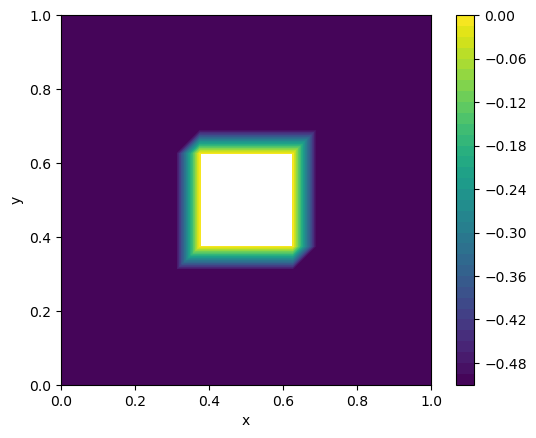

In [24]:
if model_type == 'diffusion':
    if prior_type == 'Gaussian':
        x_true = x.sample()
    elif prior_type == 'TV' or prior_type == 'TV_denoiser': 
        if signal_type == 'step':
            fun_x_true_expr = dl.Expression('x[0] > 5 ? 0 : -0.5', degree=1)

        elif signal_type == 'square':
            fun_x_true_expr = dl.Expression('(x[0]>3.5 && x[0]< 6.5) ? 0 : -0.5', degree=1)

        x_true_fun = dl.interpolate(fun_x_true_expr, H)
        x_true = cuqi.array.CUQIarray(x_true_fun.vector().get_local(), geometry=A.domain_geometry)
        
    else:
        raise ValueError('Unrecognized prior type')
    
elif model_type == 'identity' or model_type == 'convolution':
    x_true = cuqi.array.CUQIarray(np.zeros(G_domain.par_dim), geometry=A.domain_geometry)
    x_true[G_domain.par_dim//2:] = 1 + np.random.randn(G_domain.par_dim//2)*0.1

elif model_type == 'diffusion_2D':
    # set a 2D signal with a square in the middle
    fun_x_true_expr = dl.Expression('(x[0]>0.35 && x[0]< 0.65 && x[1]>0.35 && x[1]< 0.65) ? 0 : -0.5', degree=1)
    x_true_fun = dl.interpolate(fun_x_true_expr, H)
    x_true = cuqi.array.CUQIarray(x_true_fun.vector().get_local(), geometry=A.domain_geometry)



im = x_true.plot()
if physical_dim == 2:
    plt.colorbar(im[0])





This cell to compute s_noise

In [25]:

x_true.shape
y_true = A(x_true)
s_noise = 1.0/np.sqrt(G_domain.par_dim)* noise_level*np.linalg.norm(y_true)

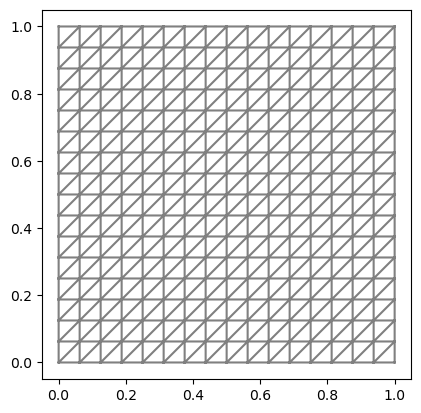

In [26]:

dl.plot(mesh)

In [27]:
np.sqrt(mesh.num_cells()/2)+1

17.0

In [28]:
if prior_type == 'Gaussian':
    cov_const = 1 #100
    x = Gaussian(np.zeros(G_domain.par_dim), cov=cov_const*smprior.cov, geometry=G_domain)
elif prior_type == 'TV':
    # CUQIpy user defined distribution
    x = cuqi.distribution.UserDefinedDistribution(logpdf_func=tv_reg.eval_density,
                                              gradient_func=tv_reg.eval_grad_density,
                                              dim=H.dim())
elif prior_type == 'TV_denoiser':
    
    
    restoration_strength = smoothing_factor * 0.5 * s_noise**2
    
    
    if physical_dim == 1:
        def prox_g(x, regularization_strength=None, restoration_strength=None):
            weight = regularization_strength * restoration_strength
            return denoise_tv_chambolle(x, weight=weight, max_num_iter=100), None
    elif physical_dim == 2:
        def prox_g(x, regularization_strength=None, restoration_strength=None):
            # x is dof of the function, create a function from the dof
            H_prox = A.domain_geometry.function_space
            x_fun = dl.Function(H_prox)
            x_fun.vector()[:] = x
            # convert to numpy array on a 2D grid
            vertices_on_axis = int(np.sqrt(A.domain_geometry.mesh.num_vertices()))
            x_grid = x_fun.compute_vertex_values().reshape((vertices_on_axis,vertices_on_axis)) 
            weight = regularization_strength * restoration_strength
            denoised_image = denoise_tv_chambolle(x_grid, weight=weight, max_num_iter=100)
            
            # reorder denoised image to dof
            # TODO: we can call dl.dof_to_vertex_map once only for performance
            d2v = dl.dof_to_vertex_map(A.domain_geometry.function_space)
            return  denoised_image.flatten()[d2v], None   
    
    
    # %%
    # We save all the important variables into the variable
    # :math:`\texttt{restorator_kwargs}`.
    restorator_kwargs = {}
    restorator_kwargs["regularization_strength"] = regularization_strength
    # %%
    # Now we can define our RestorationPrior.
    restorator = RestorationPrior(
        prox_g,
        restorator_kwargs=restorator_kwargs,
        geometry=A.domain_geometry
    )
    x = MoreauYoshidaPrior(restorator, smoothing_strength=restoration_strength)



In [29]:
y = Gaussian(A(x), s_noise**2, geometry=G_range)

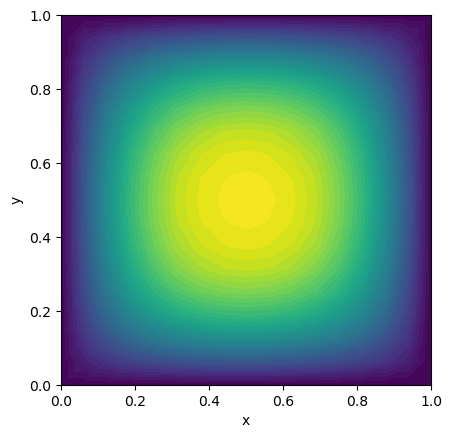

In [30]:
y_obs = y(x=x_true).sample()
y_obs.plot()
y_true.plot()

In [31]:
x.logpdf(x_true)

nan

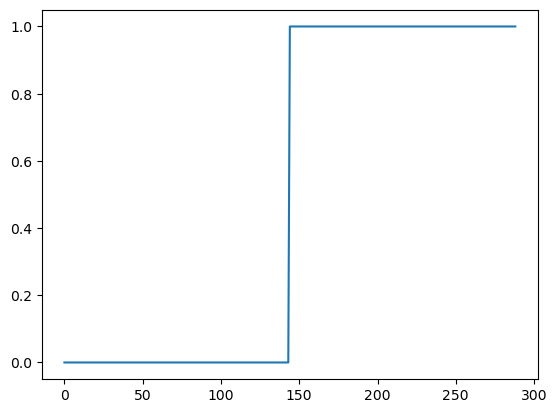

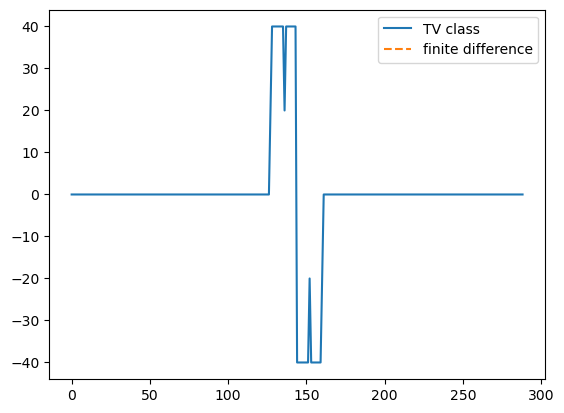

In [32]:
# x_1 = np.random.randn(G_domain.par_dim)
# x_1 step function
x_1 = np.zeros(G_domain.par_dim)
x_1[G_domain.par_dim//2:] = 1
x_1_cuqiarray = cuqi.array.CUQIarray(x_1)
x_1_cuqiarray.plot()
plt.figure()
# verify the TV gradient computation
try:
    plt.plot(x.gradient(x_1))
except:
    pass
# plot finite difference gradient 

plt.plot(approx_gradient(x.logd, x_1, 1e-12), '--')
plt.legend(['TV class', 'finite difference'])

In [33]:
if sample_prior:
    # sample the prior 
    Ns_prior = 1
    if prior_type == 'Gaussian':
        x_samples = x.sample(Ns_prior)
    
    elif prior_type == 'TV':
        prior_sampler = NUTS(x, max_depth=5)
        prior_sampler.warmup(1)
        prior_sampler.sample(Ns_prior)
        x_samples = prior_sampler.get_samples()
    
    #x_samples.plot()
    
    x_samples.plot_trace()




In [34]:
if sample_prior:
    x_samples.compute_ess()
    #x_samples.burnthin(5).plot_ci()
    plt.figure()
    x_samples.plot([-1])

In [35]:
# Set the random seed
np.random.seed(3) 

In [36]:
BP = BayesianProblem(y, x).set_data(y=y_obs)

x.logd(x_1) nan
BP.likelihood.logd(x_1) [-600129.0703825]
x.logd(0.5*x_1) nan
BP.likelihood.logd(0.5*x_1) [-404410.30621283]
x.logd(x_2) nan
BP.likelihood.logd(x_2) [-357009.07882599]


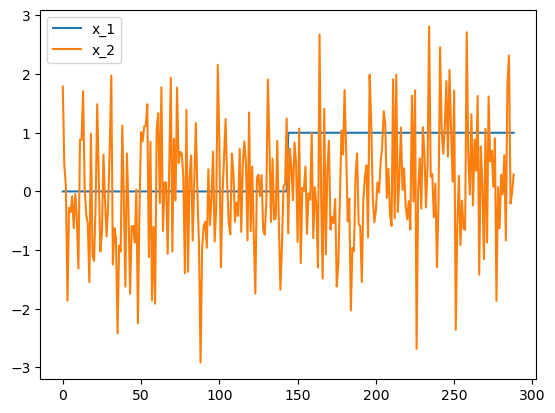

In [37]:
plt.plot(x_1, label='x_1')

x_2 = np.random.randn(G_domain.par_dim)
plt.plot(x_2, label='x_2')
plt.legend()
#print(x.logd(x_1))
#print(x.logd(x_1*0+1))
#print(x.logd(np.random.randn(G_domain.par_dim)))

# at x_1 , logd for prior and for likelihood
print('x.logd(x_1)', x.logd(x_1))
print('BP.likelihood.logd(x_1)', BP.likelihood.logd(x_1))

# at x_1 , logd for prior and for likelihood
print('x.logd(0.5*x_1)', x.logd(x_1*0.5))
print('BP.likelihood.logd(0.5*x_1)', BP.likelihood.logd(x_1*0.5))

# at x_2 , logd for prior and for likelihood
print('x.logd(x_2)', x.logd(x_2))
print('BP.likelihood.logd(x_2)', BP.likelihood.logd(x_2))

In [38]:
# map point
if enable_FD:
    BP.posterior.enable_FD() 
else:
    BP.posterior.disable_FD()
map_x = BP.MAP()


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is a work-in-progress !!!
!!!      Always validate the computed results.       !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Optimizing with exact gradients
Using scipy.optimize.minimize on negative log of Posterior
x0: ones vector


/Users/amal/Documents/research_code/CUQI-DTU/CUQIpy/cuqi/distribution/_gaussian.py:286: RuntimeWarning: overflow encountered in square
  mahadist = np.sum(np.square(self.sqrtprec @ dev.T), axis=0)
/Users/amal/Documents/research_code/CUQI-DTU/CUQIpy/cuqi/distribution/_gaussian.py:286: RuntimeWarning: overflow encountered in square
  mahadist = np.sum(np.square(self.sqrtprec @ dev.T), axis=0)


/Users/amal/opt/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'label'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


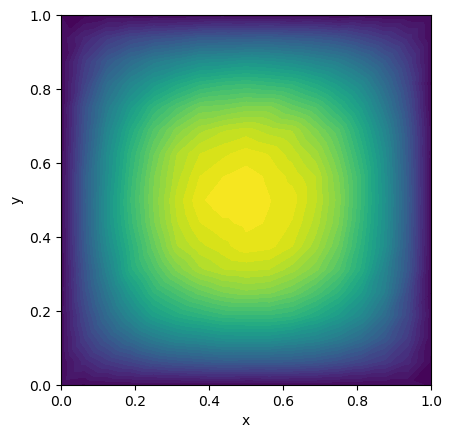

In [39]:
# plot map predicted data

y_obs.plot(label='y_obs')

if prior_type != 'TV_denoiser':
    plt.figure()
    A(map_x).plot(label='A(x_map)')
    plt.legend()


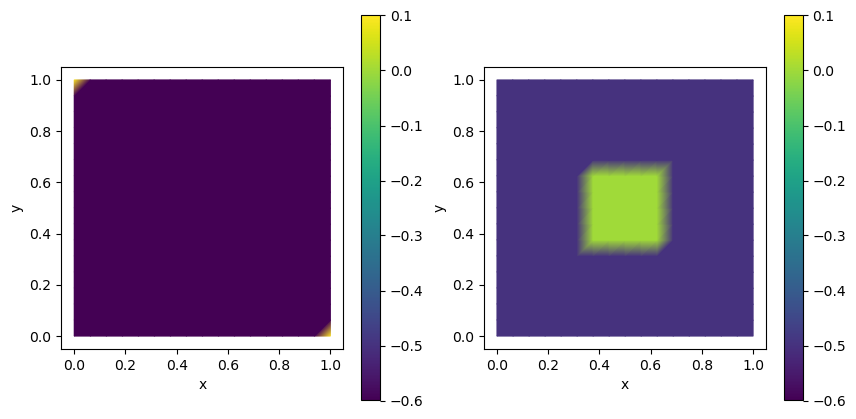

In [40]:
# create a subplot of two columns and one row
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])

if physical_dim == 2:
    im = map_x.plot(subplots=False, vmin=-0.6, vmax=0.1, mode='color')
    # min value of the colorbar is set to -1.0
    plt.colorbar(im[0])#, ticks=range(-1, 0, 5))
else:
    im = map_x.plot(subplots=False)

plt.sca(axs[1])



if physical_dim == 2:
    im = x_true.plot(subplots=False, vmin=-0.6, vmax=0.1, mode='color')
    plt.colorbar(im[0])
else:
    im = x_true.plot(subplots=False)
    plt.ylim(-1.0, 0.7)
    plt.legend(['MAP', 'True'])

In [41]:
if set_x0_map_tobe_true:
    x0_map = x_true
else:
    x0_map = x_true*0+0.25

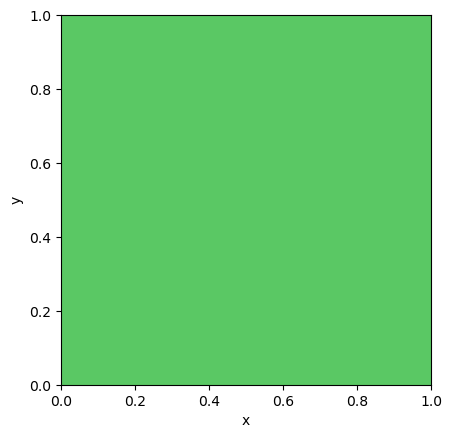

In [42]:
x0_map.plot()

In [43]:
# import scipy solver BFGS
from scipy.optimize import minimize

minimize

<function scipy.optimize._minimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)>

In [44]:
from scipy.optimize import fmin_bfgs
fmin_bfgs

<function scipy.optimize._optimize.fmin_bfgs(f, x0, fprime=None, args=(), gtol=1e-05, norm=inf, epsilon=1.4901161193847656e-08, maxiter=None, full_output=0, disp=1, retall=0, callback=None, xrtol=0, c1=0.0001, c2=0.9, hess_inv0=None)>

In [45]:
import numpy as np
from scipy.optimize import fmin_bfgs
if run_scipy_with_callback:
    Nfeval = 1
    
    
    def callbackF(Xi):
        global Nfeval
        # plot Xi every 10 iterations
        if Nfeval % 10 == 0:
            plt.plot(Xi)
            # print function value and gradient norm
            print("{0:4d}   {1: 3.6f}   {2: 3.6f}   ".format(Nfeval, 
                                                            (-BP.posterior.logd(Xi)).to_numpy()[0],
                                                            np.linalg.norm(- BP.posterior.gradient(Xi))))
            
    
           #print("{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}".format(Nfeval, Xi[0], Xi[1], Xi[2], rosen(Xi)))
        
        #print("{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}".format(Nfeval, Xi[0], Xi[1], Xi[2], rosen(Xi)))
        Nfeval += 1
    
    print('{0:4s}   {1:9s}   {2:9s}   {3:9s}   {4:9s}'.format('Iter', ' X1', ' X2', ' X3', 'f(X)')  ) 
    x0 = np.array([1.1, 1.1, 1.1], dtype=np.double)
    [xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = \
        fmin_bfgs(lambda x: -BP.posterior.logd(x),
                  x0_map*0,
                  #fprime=lambda x : -BP.posterior.gradient(x), 
                  callback=callbackF, 
                  disp=1,
                  maxiter=2000, 
                  full_output=True, 
                  retall=False,
                  gtol=5)
    


In [46]:
#plt.plot(xopt)
#plt.plot(x_true)

In [47]:
#plt.plot(xopt)
#plt.plot(x_true)

In [48]:
#print(xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg)


In [49]:
TV_beta

1e-06

In [50]:
# 35, 1e-7
if apply_grid_search:
    # grid search for computing the map
    grid_weights = [60, 90, 120]
    grid_beta = [1e-6, 1e-9] #1e-3, 1e-4, 
    map_list = []
    weight_list = []
    beta_list = []
    TV_m_list = []
    
    for i, weight in enumerate(grid_weights):
        for j, beta in enumerate(grid_beta):
            print('iteration number {} of total {}'.format(i*len(grid_beta) + j, len(grid_weights)*len(grid_beta)))
            print('weight: ', weight)
            print('beta: ', beta)
            TV_reg_i = TV_reg(H, beta=beta, weight=weight)
            # define x
            x = cuqi.distribution.UserDefinedDistribution(logpdf_func=TV_reg_i.eval_density,
                                                        gradient_func=TV_reg_i.eval_grad_density,
                                                        dim=H.dim())
            BP_i = BayesianProblem(y, x).set_data(y=y_obs)
            BP_i.posterior.disable_FD()
            map_x = BP_i.MAP(x0=x0_map)
            TV_m_list.append(TV_reg_i.TVm)
            map_list.append(map_x)
            weight_list.append(weight)
            beta_list.append(beta)
    
    
    

In [51]:
if apply_grid_search:
    if physical_dim == 1:
        # plot all map points with labels
        style = ['-', '--', '-.', ':']*3
        starting_idx = 0
        for i, map_x_i in enumerate(map_list[starting_idx:starting_idx+3]):
            map_x_i.plot(label='weight: '+str(weight_list[starting_idx+i])+' beta: '+str(beta_list[starting_idx+i]) + ' TVm: '+str(dl.assemble(TV_m_list[starting_idx+i]*dl.dx)), linestyle=style[i])
            # print(map_x_i.info)
        
        x_true.plot(label='True', color='black')
        plt.ylim(-0.6, 0.1)
        #plot f

        plt.plot(x_grid, f(x_grid)-0.5)

        # plot legend and put it outside the plot
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    elif physical_dim == 2:

        # create a subplot of two columns and one row
        fig, axs = plt.subplots(len(grid_weights), len(grid_beta), figsize=(15, 15))
        for i in range(len(grid_weights)):
            for j in range(len(grid_beta)):
                plt.sca(axs[i, j])
                im = map_list[i*len(grid_beta) + j].plot(subplots=False, vmin=-0.6, vmax=0.1, mode='color')
                plt.title('weight: '+str(weight_list[i*len(grid_beta) + j])+' beta: '+str(beta_list[i*len(grid_beta) + j]) + ' TVm: '+str(dl.assemble(TV_m_list[i*len(grid_beta) + j]*dl.dx)))
                plt.colorbar(im[0])

    else:
        raise ValueError('Unrecognized physical dimension')

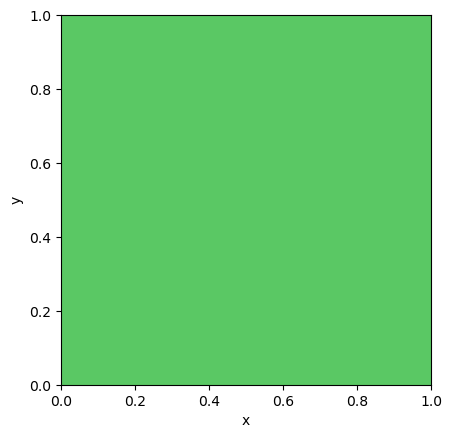

In [52]:

x0_map.plot()

In [53]:
map_x.info

{'success': False,
 'message': 'Desired error not necessarily achieved due to precision loss.',
 'func': nan,
 'grad': array([25.68649229,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
      

In [54]:
#posterior_samples = BP.UQ(Ns=3000, Nb=2, percent=97)
posterior = BP.posterior()
#sampler = cuqi.sampler.NUTS(posterior, max_depth=4, x0=np.zeros(G_domain.par_dim)+.001)
#sampler = cuqi.sampler.ULA(posterior, x0=np.zeros(G_domain.par_dim)+.001, scale=0.00000005)
# np.zeros(G_domain.par_dim)+.001

#initial_point = np.zeros(G_domain.par_dim) # x_true.to_numpy()
#initial_point = 0.5*map_x.to_numpy()
#initial_point = map_x.to_numpy()
initial_point = np.ones(G_domain.par_dim)*-0.25

#sampler = cuqi.experimental.mcmc.PCN(posterior, initial_point=initial_point, scale=0.05)#, max_depth=10, scale=0.005)

if sampler_choice == "NUTS":
    sampler = cuqi.experimental.mcmc.NUTS(posterior,
                                          initial_point=initial_point,
                                          max_depth=max_depth,
                                          step_size=step_size)

elif sampler_choice == "MALA":
    sampler = cuqi.experimental.mcmc.MALA(posterior, initial_point=initial_point, scale=2.1e-7)
    Ns = 1000
    Nb = 20

elif sampler_choice == "ULA":
    sampler = cuqi.experimental.mcmc.ULA(posterior, initial_point=initial_point, scale=2.1e-7)


elif sampler_choice == "MH":
    sampler = cuqi.experimental.mcmc.MH(posterior, initial_point=initial_point, scale=2.1e-5)
    Ns = 1000
    Nb = 20

elif sampler_choice == "myULA":

    sampler = ULA(posterior, scale=1e-4, initial_point=initial_point)



_ = sampler.warmup(Nb)
_ = sampler.sample(Ns)


#posterior_samples = sampler.sample_adapt(100, Nb=10)

Sample: 100%|██████████| 2000/2000 [01:09<00:00, 28.65it/s, acc rate: 100.00%]


In [55]:
posterior.prior


CUQI MoreauYoshidaPrior.

In [56]:
remove_burnin

200

In [57]:

posterior_samples = sampler.get_samples().burnthin(remove_burnin)

In [58]:
try:
    print(sampler.scale)
except:
    pass

0.0001


In [59]:
try:
    plt.plot(sampler.num_tree_node_list)
    plt.figure()
    plt.semilogy(sampler.epsilon_list)
    plt.semilogy(sampler.epsilon_bar_list)
    print(np.max(sampler.epsilon_list))
except:
    pass

In [60]:
2**7

128

In [61]:
# sampler.scale

Code cell for generating Figure 1

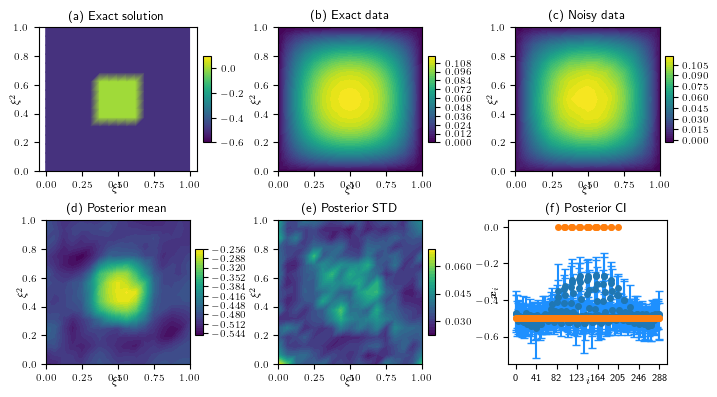

In [77]:

if model_type == 'diffusion' or model_type == 'diffusion_2D':

    import os
    from matplotlib import ticker
    import matplotlib.pyplot as plt
    
    # Set up matplotlib
    SMALL_SIZE = 7
    MEDIUM_SIZE = 8
    BIGGER_SIZE = 9
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    # Use latex package
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{bm}')
    
    # Data directory
    fig_dir = './figs/'
    
    # Figure file
    fig_dir = fig_dir 
    
    # Check if the directory exists
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    
    # Figure version
    version = 'v8'
    
    # Figure file
    fig_file = fig_dir + 'paper_figure1_'+version+'.pdf'
    
    # Create the figure
    cm_to_in = 1/2.54
    fig, axs = plt.subplots(nrows=2, ncols=3,
                            figsize=(17.8*cm_to_in, 9.8*cm_to_in),
                            layout="constrained")
    
    # Define the colors to be used in the plots
    colors = ['C0', 'green', 'purple', 'k', 'gray']
    
    # (a)
    plt.sca(axs[0,0])
    
    
    if physical_dim == 2: 
        im = x_true.plot(subplots=False, vmin=-0.6, vmax=0.1, mode='color')
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
    else:
        im = x_true.plot(subplots=False)
    
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_title('(a) Exact solution')
    plt.ylabel('$\\xi^2$')
    plt.gca().yaxis.labelpad = -5
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    
    # (b)
    plt.sca(axs[0,1])
    im = y_true.plot(subplots=False)
    
    if physical_dim == 2:
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
        plt.gca().set_title('(b) Exact data')
    else:
        samples_mean = cuqi.array.CUQIarray(posterior_samples.mean(), geometry=G_domain)
        A(samples_mean).plot(subplots=False)
        plt.gca().set_title('(b) Exact and predicted data')
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    
    
    # (c)
    plt.sca(axs[0,2])
    im = y_obs.plot(subplots=False)
    if physical_dim == 2:
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    plt.gca().set_title('(c) Noisy data')
    
    # (d)
    plt.sca(axs[1,0])

    if physical_dim == 2:
        im = posterior_samples.plot_mean(
            subplots=False)#, vmin=-0.6, vmax=0.1, mode='color')
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    else:
        im = posterior_samples.plot_mean(subplots=False)
    
    #plt.gca().set_xlim(0, 1)
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    plt.gca().set_title('(d) Posterior mean')
    
    # (e)
    plt.sca(axs[1,1])
    im = posterior_samples.funvals.vector.plot_std(subplots=False)
    
    if physical_dim == 2:
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        cb = fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        cb.locator = ticker.MaxNLocator(nbins=4)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    plt.gca().set_title('(e) Posterior STD')
    
    # (f)
    plt.sca(axs[1,2])
    lci = posterior_samples.plot_ci(
        97, exact=x_true, plot_par=True, markersize=SMALL_SIZE-3)
    lci[0].set_label("Mean")
    lci[1].set_label("Exact")
    lci[2].set_label("$97\\%$ CI")
    #plt.ylim(-5, 3)
    plt.legend(ncols=2) 
    plt.ylabel(r'$\bm{x}_i$')
    plt.gca().yaxis.labelpad = -5
    plt.gca().yaxis.set_label_coords( -0.06, 0.5)
    plt.xlabel('$i$')
    plt.gca().xaxis.labelpad = -5
    plt.gca().set_title('(f) Posterior CI')
    n_ticks = 8
    num_var = posterior_samples.geometry.par_dim
    tick_ids = np.linspace(0, num_var-1, n_ticks, dtype=int)
    plt.xticks(tick_ids, tick_ids)
    # switch legend off
    plt.gca().legend().set_visible(False)
    
    # Save the figure
    plt.savefig(fig_file, bbox_inches='tight', pad_inches=0.01, dpi=1200)

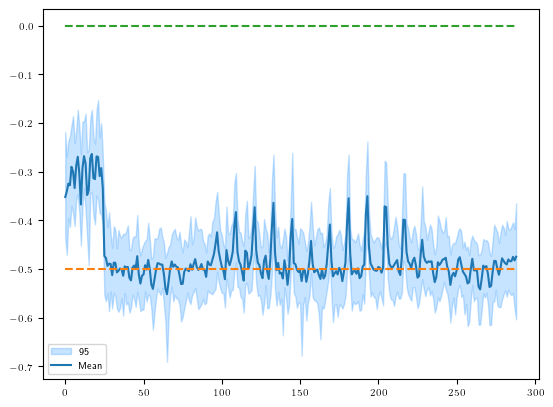

In [63]:
# from exact solution extract indices of the square
if model_type == 'diffusion_2D':
    indices_of_square = np.where(x_true.to_numpy() > -0.2)[0]

reordered_samples = np.zeros_like(posterior_samples.samples)
reordered_samples[ :len(indices_of_square), :] = posterior_samples.samples[ indices_of_square, :]
reordered_samples[ len(indices_of_square):, :] = posterior_samples.samples[ np.setdiff1d(np.arange(G_domain.par_dim), indices_of_square), :]

reordered_CUQI_samples = cuqi.samples.Samples(reordered_samples)

reordered_CUQI_samples.plot_ci()
plt.plot(np.ones(G_domain.par_dim)*-0.5, '--')
plt.plot(np.ones(G_domain.par_dim)*0, '--')

Run for multiple cases:

mesh = 16 by 16, 32 by 32, 64 by 64 (3 options)
TV_weight = 10, 20, 30 (3 options)
smoothing_factor = 0.005, 0.01, 0.02 (3 options)
number of samples = 2000 * 25 (1 min)

In [64]:
ess_list = posterior_samples.compute_ess()
print(ess_list)
print(np.min(ess_list))
print(np.max(ess_list))
print(np.mean(ess_list))

[20.55678969 24.5963667  40.09415894  3.59101436 14.92704248 46.48892772
 37.37104339 27.51009036 33.33623368 56.33534156 38.33223723 49.77632906
 28.40825268 26.91405599 29.89434876 17.46506882 34.31773509 11.87592044
 19.07060067 17.63965801 31.8396196  32.47934115 30.36522142 61.15842449
 22.84973024 11.5631735  68.04575762 40.83338052 51.10207254 49.53388328
 29.4237429  37.66586414 35.32001187 17.05337883 15.60358877 41.53806278
 16.10302997 16.78874653 42.55941031 35.80736601  9.3200513  38.0702981
  6.1505746  33.72668176 20.86031232 22.79614016 28.76218675 41.02540167
 40.07780314  6.42336657 23.7645736  29.03962619 21.85678211 29.67546
 47.87102337 29.24040134 43.01196717 34.0933718  29.67008782 29.98018799
 29.80661331  6.65986139 12.69796977 35.96033065 56.35076327 47.98122462
  7.41957269  5.30763012 49.65777382 39.76594567 16.38547695 31.47134176
 35.22757312 46.10741506 41.12238463 38.49280788 21.86683784 26.53041656
 20.76436307 39.54290456 24.92449182 40.89045996 49.834

Selecting 5 randomly chosen variables


array([[<AxesSubplot: title={'center': 'x111'}>,
        <AxesSubplot: title={'center': 'x111'}>],
       [<AxesSubplot: title={'center': 'x126'}>,
        <AxesSubplot: title={'center': 'x126'}>],
       [<AxesSubplot: title={'center': 'x249'}>,
        <AxesSubplot: title={'center': 'x249'}>],
       [<AxesSubplot: title={'center': 'x42'}>,
        <AxesSubplot: title={'center': 'x42'}>],
       [<AxesSubplot: title={'center': 'x58'}>,
        <AxesSubplot: title={'center': 'x58'}>]], dtype=object)

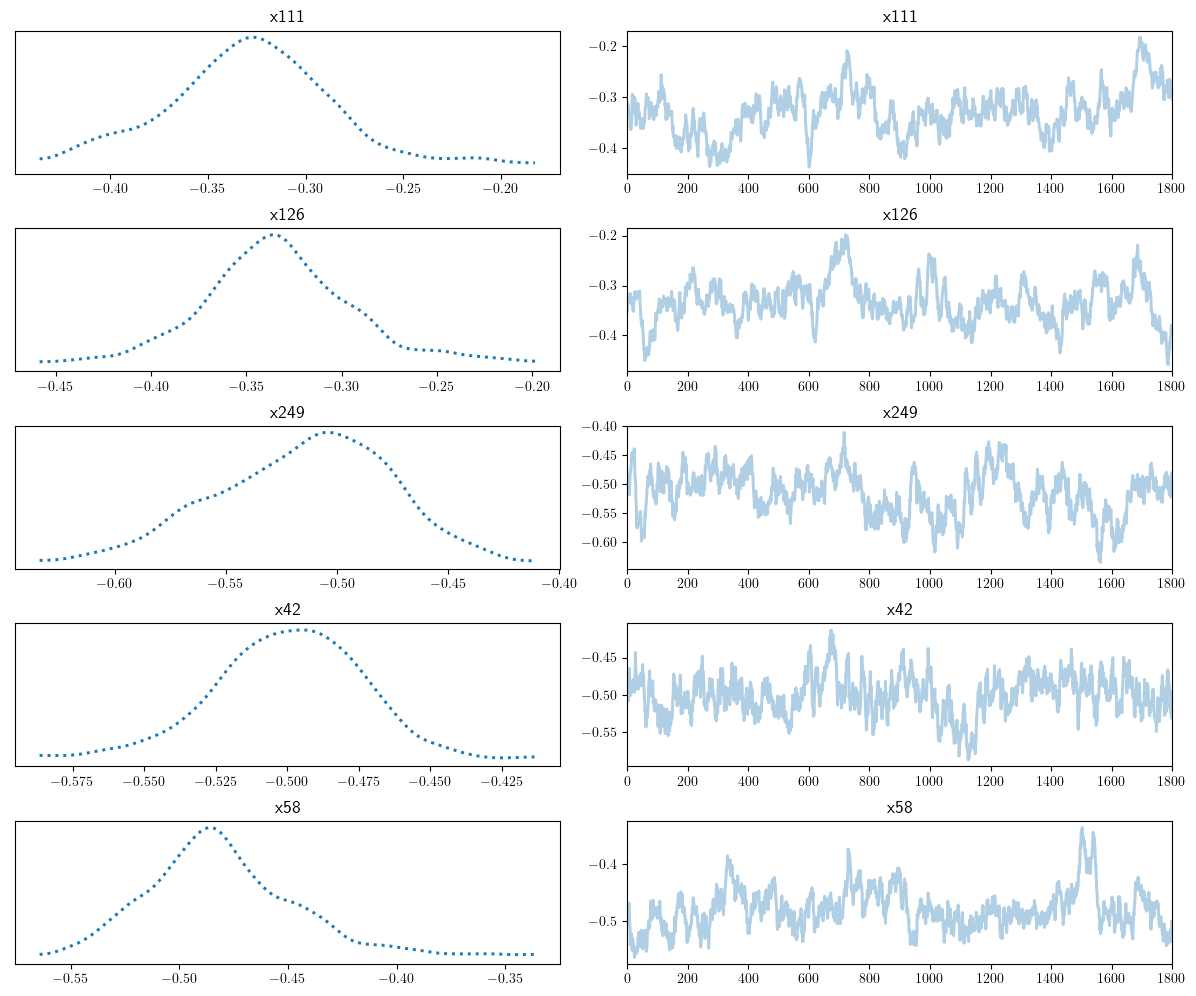

In [65]:
posterior_samples.plot_trace()

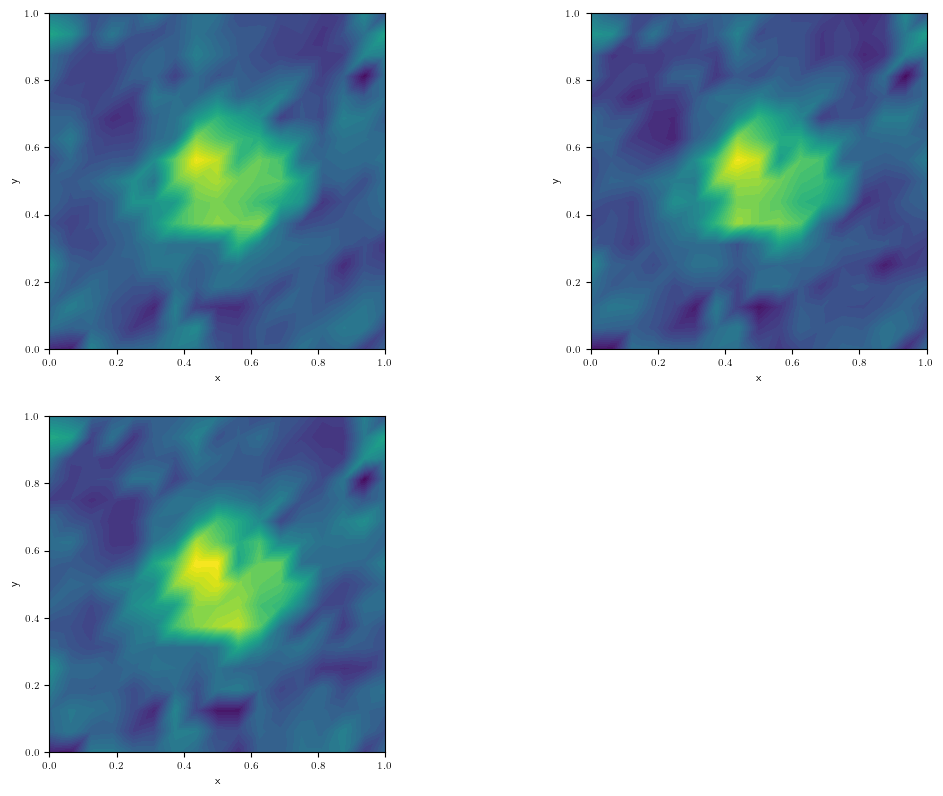

In [66]:
posterior_samples.plot([-1, -3, -5])

Plotting 5 randomly selected samples
Plotting 5 randomly selected samples


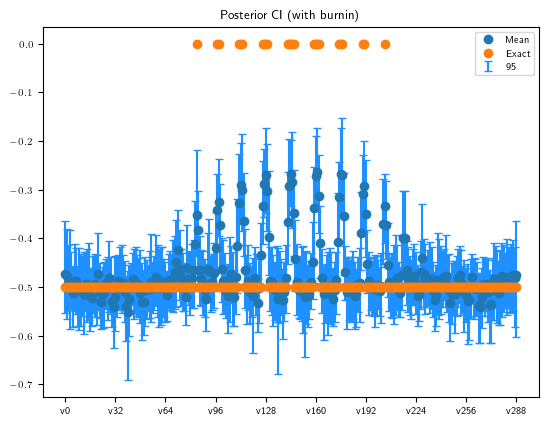

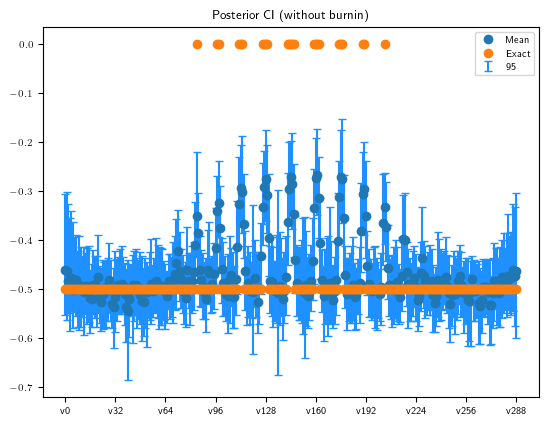

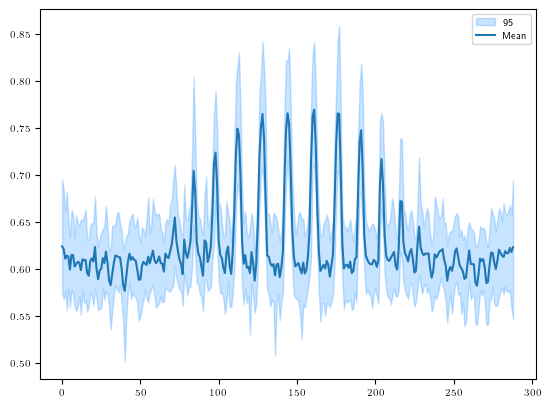

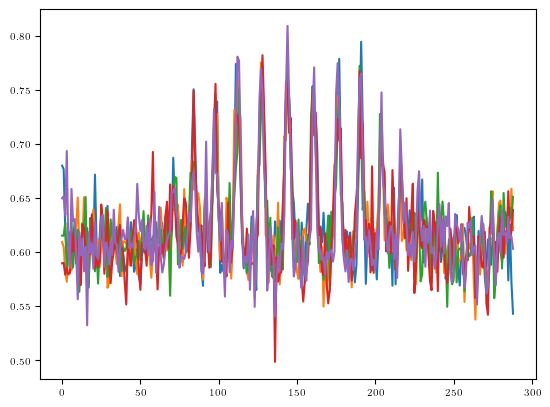

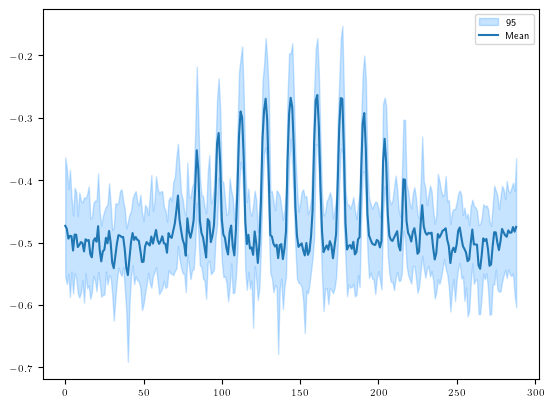

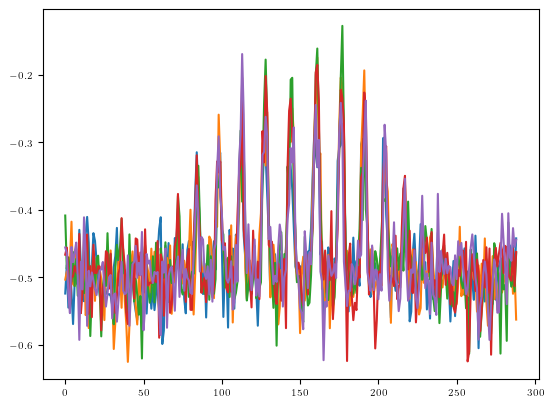

In [67]:


posterior_samples.plot_ci(exact=x_true, plot_par=plot_par)
plt.title('Posterior CI (with burnin)')
plt.figure()
sampler.get_samples().plot_ci(exact=x_true, plot_par=plot_par)
plt.title('Posterior CI (without burnin)')
plt.figure()
mapped_samples = cuqi.samples.Samples( np.exp(posterior_samples.samples))
mapped_samples.plot_ci()
plt.figure()
mapped_samples.plot()

plt.figure()
samples_geom2 = cuqi.samples.Samples( posterior_samples.samples)
samples_geom2.plot_ci()
plt.figure()
samples_geom2.plot()

In [68]:
# - [x] 1D case 
# - [ ] DG0
# - [ ] TV with non-MY gradient and with NUTS 
# - [x] verify the gradient of the posterior
# - [x] PCN seems to work (for both 1D and 2D cases)
# - [x] Start from x0=the true parameter to debug

## Verify gradient  (model)

0.029651792793713938


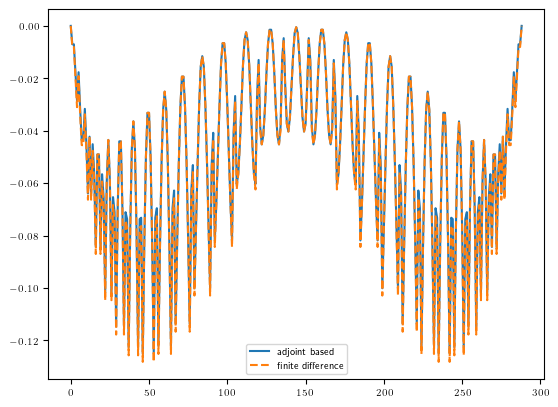

In [69]:


np.random.seed(3)
# random direction y
y0 = np.ones(G_range.par_dim) # np.random.randn(G_range.par_dim)
y0[0] = 0
y0[-1] = 0

# corresponding fenics function
y0_fun = dl.Function(H)
y0_fun.vector()[:] = y0

# objective function
def f(x):
    return A(x).T@ y0.reshape(-1,1)
    #return A(x).vector().get_local().T@ y0.reshape(-1,1)

# objective function gradient
def fprime(x):
    return A.gradient(y0, x)

# random input x (the point which gradient is calculated with respect to)
x0 = np.random.randn(G_domain.par_dim)

# assert that the gradient is correct
print(check_grad(f, fprime, x0))

plt.plot(fprime(x_true))
# plot finite difference gradient 

plt.plot(approx_gradient(f, x_true, 1e-6), '--')
plt.legend(['adjoint based', 'finite difference'])


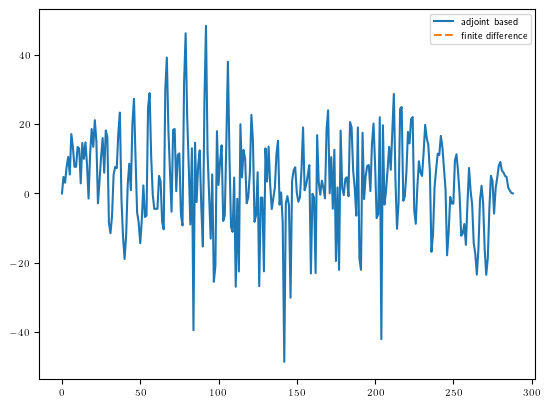

In [70]:
## Verify gradient  (posterior)

plt.plot(posterior.gradient(x_true))
# plot finite difference gradient 

plt.plot(approx_gradient(posterior.logd, x_true, 1e-8), '--')
plt.legend(['adjoint based', 'finite difference'])

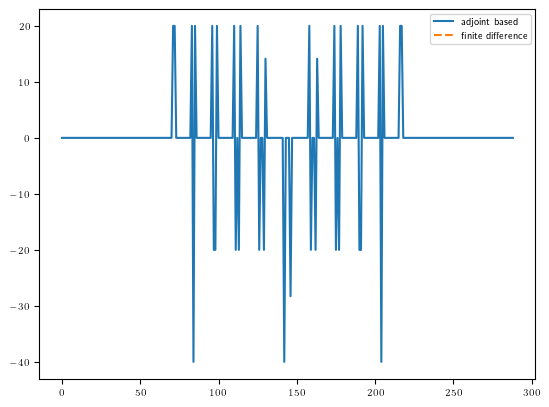

In [71]:
# check the gradient of the prior

plt.plot(x.gradient(x_true))
# plot finite difference gradient 

plt.plot(approx_gradient(x.logd, x_true, 1e-8), '--')
plt.legend(['adjoint based', 'finite difference'])

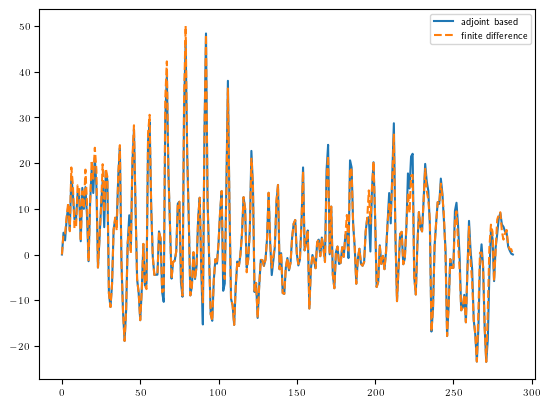

In [72]:
# check the gradient of the likelihood

plt.plot(posterior.likelihood.gradient(x_true))
# plot finite difference gradient 

plt.plot(approx_gradient(posterior.likelihood.logd, x_true, 1e-10), '--')
plt.legend(['adjoint based', 'finite difference'])